<a href="https://colab.research.google.com/github/MahanNasirkhani/Mask-Detection/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.applications import VGG16

# Load Dateset

In [3]:
train_dir = '/content/drive/MyDrive/Mask Dataset/Train'
test_dir = '/content/drive/MyDrive/Mask Dataset/Test'

In [4]:
batch_size = 32
img_height = 100
img_width = 100

In [30]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4926 files belonging to 2 classes.
Using 3941 files for training.
Found 4926 files belonging to 2 classes.
Using 985 files for validation.
Found 1026 files belonging to 2 classes.


In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds_1 = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Augmentation layers

In [56]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1 , fill_value=0.1),
    layers.RandomContrast(factor = 0.1),
    layers.RandomBrightness(factor = 0.1)
  ]
)

# VGG16 model and layers

In [57]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(100, 100, 3))

In [58]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Model

In [59]:
model = models.Sequential()
model.add(data_augmentation)
model.add(layers.Rescaling(1./255))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))

In [60]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               589952    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [61]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate = 2e-5),
              metrics=['accuracy'])

# Training

In [62]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

In [63]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[checkpoint])

Epoch 1/10
124/124 [==============================] - 11s 78ms/step - loss: 0.1584 - accuracy: 0.9355 - val_loss: 0.0609 - val_accuracy: 0.9827
Epoch 2/10
124/124 [==============================] - 9s 74ms/step - loss: 0.0574 - accuracy: 0.9789 - val_loss: 0.0625 - val_accuracy: 0.9858
Epoch 3/10
124/124 [==============================] - 9s 77ms/step - loss: 0.0498 - accuracy: 0.9843 - val_loss: 0.0521 - val_accuracy: 0.9878
Epoch 4/10
124/124 [==============================] - 9s 76ms/step - loss: 0.0337 - accuracy: 0.9904 - val_loss: 0.0565 - val_accuracy: 0.9878
Epoch 5/10
124/124 [==============================] - 10s 81ms/step - loss: 0.0399 - accuracy: 0.9896 - val_loss: 0.0746 - val_accuracy: 0.9848
Epoch 6/10
124/124 [==============================] - 10s 77ms/step - loss: 0.0268 - accuracy: 0.9906 - val_loss: 0.0445 - val_accuracy: 0.9929
Epoch 7/10
124/124 [==============================] - 10s 78ms/step - loss: 0.0245 - accuracy: 0.9919 - val_loss: 0.0508 - val_accuracy: 0.

# Plotting accuracy and loss

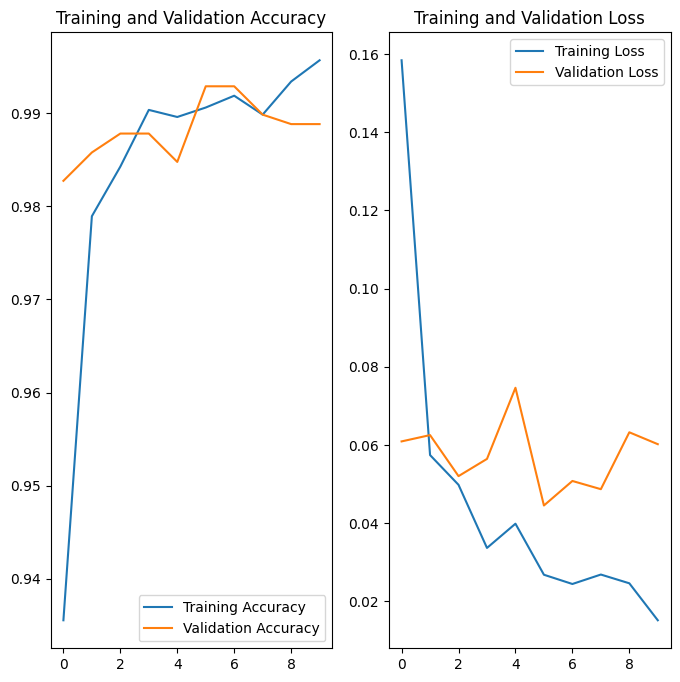

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Testing the model

In [65]:
from keras.models import load_model

best_model = load_model('best_model.h5')

In [66]:
loss, acc = best_model.evaluate(test_ds_1)
print('\nTesting loss: %.2f, acc: %.2f%%'%(loss, acc))

33/33 [==============================] - 1s 33ms/step - loss: 0.1838 - accuracy: 0.9522

Testing loss: 0.18, acc: 0.95%
